In [2]:
# Warning: usually don't do this kind of inclusion : using *, you 'merge' the namespaces
#          but in this case we actually want to mimic the imports as if they were imported here
from src.setup import *
from Pyhattan import FormatData, GenerateManhattan
import scipy.stats as stats
import scipy.cluster.hierarchy as sch

# This prevents to restart the kernel whenever an external file is edited
%load_ext autoreload
%autoreload 2

from src import common
from src import host

# Introduction

At this point, we expect to have **clean** viral and host data (filtered for missingness, rare variants, hardy-weinberg equilibrium). We also assume that there is a file containing all the individuals (IGM ids) that are in all the datasets (we will use this together with `--keep-fam` command of plink).

We will first filter out the individuals that are missing in any of the three datasets (viral sequencing data, host sequencing data, clinical data) by using a custom function `common.find_individuals`. Then we will run some PCAs and association tests (univariate and multivariate models, i.e. corrected for sex, age, population stratification, ...). Eventually, we'll focus on asian individuals.

## Method

We use a custom `host.plot_plink_pca` function that looks at the plink PCA data and automatically merges a variable of the clinical data.

# Principal component analysis

We want to **exclude the chromosomes 6, X and Y**. We first compute the PCA for all individuals, then for asian people.

## plink PCA computation

We use the `--keep-fam <file>` command to keep individuals that are in all datasets. 

In [15]:
host.run_plink("--pca 20 --keep-fam " + PATH_INTERSECTING_INDIVIDUALS+" --not-chr 0 6 X Y XY",
                file=PATH_HOST_CLEAN_DATA, out=PATH_HOST_CLEAN_DATA,
                extension='eigenvec', log_name='host_pca', force=True);

Running 'plink2 --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --pca 20 --keep-fam data/individuals/intersecting_ids --not-chr 0 6 X Y XY '
Log written to 'data/plink/log/host_pca.log'


## All individuals


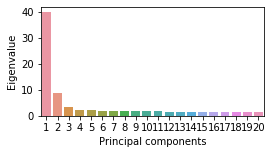

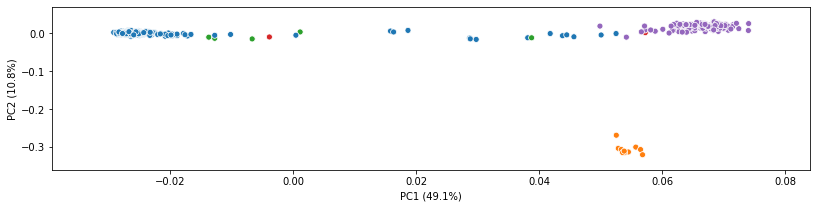

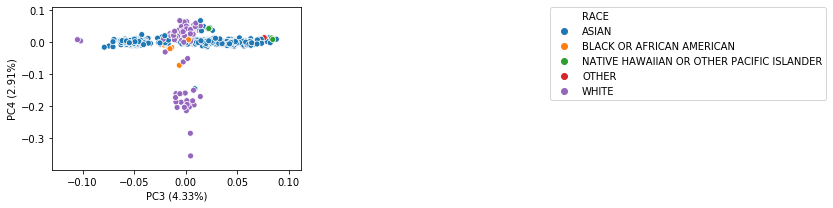

In [16]:
host.plot_plink_pca(PATH_HOST_CLEAN_DATA, n_pcs=4, hue_col='RACE',
                   bbox_to_anchor=(2, 1))

In [263]:
#host.plot_plink_pca(PATH_HOST_CLEAN_DATA, n_pcs=4, hue_col='GT',
#                   bbox_to_anchor=(2, 1))

# Association analyses

Starting from now, all the computations are done with `PATH_WORKING_DATASET` defined in `setup.py` so make sure this variable targets the right dataset.

We will make use of the `write_phenotypes` function to create a file that plink can read as phenotypes. Plink sees phenotypes as response variable / outcome of a regression or association model. 

## Simple univariate model

### BMI

In [229]:
pheno = 'BASELINE_BMI'

In [271]:
# We write the BMI of asian individuals
common.write_phenotypes(PATH_HOST_CLEAN_DATA, phenotype=pheno, 
                        criteria=('RACE', 'ASIAN'), output_path=PATH_WORKING_PHENOTYPES)
o, e = host.run_assoc()

440 individuals written to 'data/working_pheno'
170 were filtered out based on the criteria ('RACE', 'ASIAN')
The phenotype 'BASELINE_BMI' was included.
Running 'plink2 --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --not-chr 0 6 X Y XY MT --keep data/working_pheno --linear --pheno data/working_pheno '


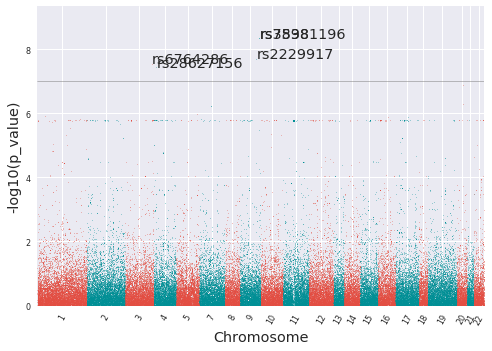

In [227]:
data = FormatData(PATH_HOST_CLEAN_DATA+'.BASELINE_BMI.glm.linear', sep='\s+', chromosome='#CHROM', 
                  p_value='P')
GenerateManhattan(data, refSNP='ID', significance=7)

In [235]:
df = pd.read_csv(PATH_HOST_CLEAN_DATA+'.BASELINE_BMI.glm.linear', sep='\s+',
                 usecols=['P'])
#df['-log10P'] = df.P.apply(lambda x: - np.log10(x))

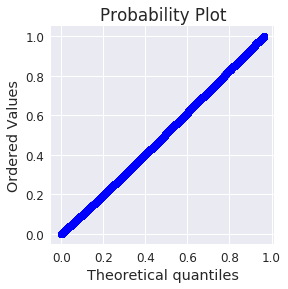

In [269]:
plt.figure(figsize=(4,4))
stats.probplot(df['P'], dist='uniform', plot=plt);

### Random vectors N(0, 1)

In [300]:
common.write_phenotypes(PATH_HOST_CLEAN_DATA, phenotype='random', 
                        criteria=('RACE', 'ASIAN'), output_path=PATH_WORKING_PHENOTYPES, verbose=False)
o, e = host.run_assoc()
#print(o)

Running 'plink2 --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --not-chr 0 6 X Y XY MT --keep data/working_pheno --linear --pheno data/working_pheno '


In [301]:
print(o)

PLINK v2.00a2LM 64-bit Intel (31 Jul 2019)     www.cog-genomics.org/plink/2.0/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/plink/host_geno_clean.log.
Options in effect:
  --bfile data/plink/host_geno_clean
  --glm
  --keep data/working_pheno
  --not-chr 0 6 X Y XY MT
  --out data/plink/host_geno_clean
  --pheno data/working_pheno

Start time: Thu Aug 15 18:34:01 2019
64232 MiB RAM detected; reserving 32116 MiB for main workspace.
Allocated 24087 MiB successfully, after larger attempt(s) failed.
Using up to 16 threads (change this with --threads).
612 samples (0 females, 0 males, 612 ambiguous; 612 founders) loaded from
data/plink/host_geno_clean.fam.
104257 out of 139720 variants loaded from data/plink/host_geno_clean.bim.
10 quantitative phenotypes loaded.
--keep: 440 samples remaining.
440 samples (0 females, 0 males, 440 ambiguous; 440 founders) remaining after
main filters.
Calculating allele frequencies... 0%55%done.
--glm li

In [296]:
df = pd.read_csv(PATH_HOST_CLEAN_DATA+'.1.glm.linear', sep='\s+',
                 usecols=['P'])

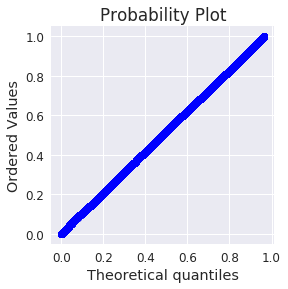

In [297]:
plt.figure(figsize=(4,4))
stats.probplot(df['P'], dist='uniform', plot=plt);

### Amino acids

We'll consider `gene_PC_C_pos_0160_A` and `gene_S_pos_0035_R`. The binary variable makes the association a case-control study for that specific amino acid. 

In [67]:
common.write_phenotypes(PATH_HOST_CLEAN_DATA, phenotype=('PC', 160, 'A'), 
                        criteria=('RACE', 'ASIAN'), output_path=PATH_WORKING_PHENOTYPES, 
                        verbose=False)
o, e = host.run_assoc(binary=True)

Running 'plink2 --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --not-chr 0 6 X Y XY MT --allow-no-sex --logistic --1 --pheno data/working_pheno --keep data/working_pheno '


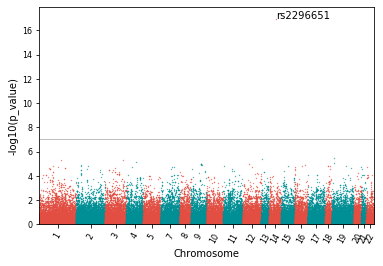

In [68]:
data = FormatData(PATH_HOST_CLEAN_DATA+'.assoc.logistic', sep='\s+', chromosome='CHR', 
                  p_value='P')
GenerateManhattan(data, refSNP='SNP', significance=7)

In [63]:
common.write_phenotypes(PATH_HOST_CLEAN_DATA, phenotype=('S', 35, 'R'), 
                        criteria=('RACE', 'ASIAN'), output_path=PATH_WORKING_PHENOTYPES, 
                        verbose=False)
o, e = host.run_assoc(binary=True, plink2=False)

Running 'plink --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --not-chr 0 6 X Y XY MT --allow-no-sex --logistic --1 --pheno data/working_pheno --keep data/working_pheno '


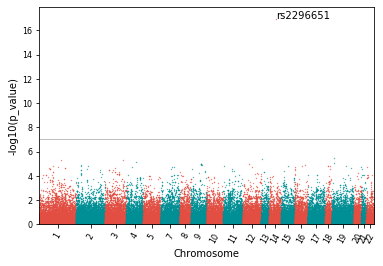

In [66]:
data = FormatData(PATH_HOST_CLEAN_DATA+'.assoc.logistic', sep='\s+', chromosome='CHR', 
                  p_value='P')
GenerateManhattan(data, refSNP='SNP', significance=7)

## Report

For both `gene_PC_C_pos_0160_A` and `gene_S_pos_0035_R` amino acids, we observe a very significant association with the `rs2296651` SNP. From articles:

[The rs2296651 (S267F) variant on NTCP (SLC10A1) is inversely associated with chronic hepatitis B and progression to cirrhosis and hepatocellular carcinoma in patients with chronic hepatitis B.](https://www.ncbi.nlm.nih.gov/pubmed/26642861)
> Sodium taurocholate cotransporting polypeptide (NTCP) is a functional receptor for hepatitis B virus (HBV) infection. NTCP rs2296651 is believed to be an Asian‐specific variant responsible for HBV susceptibility.

# Clustering

Refer to the Statistics notebook and to the reference book specified below. Clustering is a type of problem in unsupervised learning together with dimensional reduction (PCA) and other ones. Clustering aims to partition unlabeled data items into disjoint subsets of clusters that have:

* high interclass similarity
* low interclass similarity

###### Types of input

* similarity-based clustering: input is nxn matrix
* feature-based clustering: input is nxD design matrix

###### Clustering techniques

* soft partition: probabilistic model
* hard partition: assign well defined membership 
    * paritional (ex K-means, spectral clustering)
    * hierarchichal

Here we need **hierarchical** hard partition clustering. 

###### References

This *Clustering* section of the notebook is based on the following book (except when a link is present): Santi Seguí, and Laura Igual. *Introduction to Data Science : A Python Approach to Concepts, Techniques and Applications*, (*CH7 Unsupervised learning*). Web.

## Hierarchichal clustering

> [...] algorithms that construct nested clusters by successive merging or splitting of data. The hierarchy of clusters is represented as a tree. The tree is usually called a **_dendrogram_**. The root of the dendrogram is the single cluster that contains all the samples; the leaves are the clusters containing only one sample each. This is a nice tool, since it can be straightforwardly interpreted: it “explains” how clusters are formed and
visualizes clusters at different scales. The tree that results from the technique shows the *similarity between the samples*. Partitioning is computed by **selecting a cut on the tree** at a certain level.

###### Types of hierarchichal clustering:

* top-down: start with all data in one cluster, iteratively splits clusters
* bottom-up: start with each datapoint in a different cluster, iteratively merges clusters

###### Measure similarity - bottom up

Linkage criterion defines some metrics used in agglomerative clustering:

* Maximum or complete linkae minimizes distance between observations of pairs of clusters. Tend to give clusters a spherical shape. 
* Average linkage averages similarity between members thus minimizes the mean distance between all possible pair of clusters.
* **Ward** linkage minimizes the sum of squared differences within all clusters. It's a variance minimizing approach.

###### Add constraints

Useful to impose a certain local structure and makes the algorithm faster, via a *connectivity matrix* (ex can be learned from the data with `kneighbors_graph`). 

###### [Example](https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/)

In [16]:
import scipy.cluster.hierarchy as hierarchy
from scipy.cluster.hierarchy import dendrogram

In [20]:
X = np.array([[5,3], [10,15], [15,12], [24,10], [30,30], [85,70], [71,80],
            [60,78], [70,55], [80,91],])
Z = hierarchy.linkage(X, 'single')
labels = range(11)

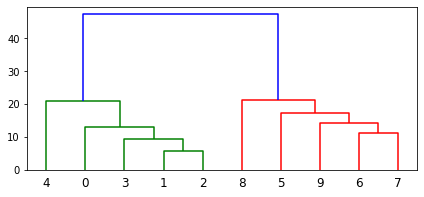

In [23]:
plt.figure(figsize=(7,3))
dn1 = dendrogram(Z)

We explicitely see the **bottom-up** aspect of this kind of clustering.

## Load the pcs

In [17]:
df_pca = pd.read_csv(PATH_HOST_CLEAN_DATA+'.eigenvec', sep="\s+")

## Clustering with scipy

https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/Hierarchical_Clustering.ipynb

In [3]:
import scipy.cluster.hierarchy as sch

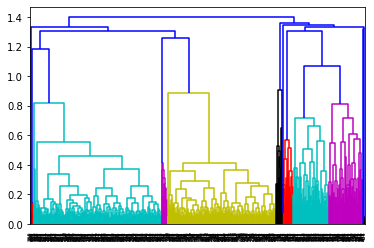

In [19]:
dendrogram = sch.dendrogram(sch.linkage(df_pca.drop(['#FID', 'IID'], axis=1), method = 'ward'))

In [87]:
from sklearn.cluster import AgglomerativeClustering

In [92]:
ward = AgglomerativeClustering(n_clusters=10)
clusters = ward.fit_predict(df_pca.drop(['#FID', 'IID'], axis=1))

In [95]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

TypeError: 'dict' object is not callable

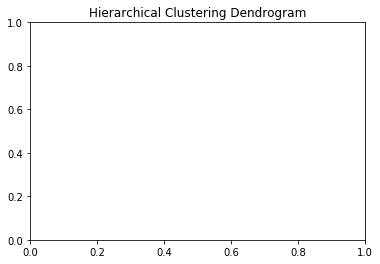

In [96]:
model = AgglomerativeClustering(n_clusters=3)

model = model.fit(df_pca.drop(['#FID', 'IID'], axis=1))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, labels=model.labels_)

## Clustering with plink

From [the doc](https://www.cog-genomics.org/plink/1.9/formats#cluster);

> .cluster1 files contain one line per cluster, with a cluster name in front ('SOL-0', 'SOL-1', ...), followed by IDs of the cluster's members (formatted as FID + '_' + IID + possibly case/control status in parentheses).
> 
> .cluster3{,.missing} files contain one line per sample, with their FID and IID as the first two fields (not merged with an underscore here), followed by a sequence of nonnegative integers representing the sample's cluster assignment at each stage of the clustering process.

In [84]:
o, e = host.run_plink("--ppc 0.01 --cluster", file=PATH_HOST_CLEAN_DATA, out=PATH_HOST_CLEAN_DATA, 
         extension='cluster1', plink2=False, force=True)

Running 'plink --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --ppc 0.01 --cluster '
treat these as missing.



In [85]:
df_cluster = pd.read_csv(PATH_HOST_CLEAN_DATA+'.cluster2', sep='\s+', header=None)
df_cluster[2].value_counts()

11    38
8     36
21    32
5     29
1     25
      ..
39     1
38     1
61     1
33     1
62     1
Name: 2, Length: 63, dtype: int64

## Use pandas-plink


In [23]:
from pandas_plink import read_plink1_bin
geno_array = read_plink1_bin(PATH_HOST_CLEAN_DATA+'.bed')
type(geno_array)

Mapping files: 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]


xarray.core.dataarray.DataArray

We have an [xarray.DataArray](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) element:

> The API is similar to that for the pandas Series or DataFrame, but DataArray objects can have any number of dimensions, and their contents have fixed data types.

In [43]:
print("Dimensions of the array:", geno_array.dims)
print(geno_array.coords)

Dimensions of the array: ('sample', 'variant')
Coordinates:
  * sample   (sample) object 'igm160017' 'igm160019' ... 'igm160905' 'igm160906'
  * variant  (variant) object '1_1:14932:G:T' ... 'MT_rs193302985'
    father   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    fid      (sample) <U9 'igm160017' 'igm160019' ... 'igm160905' 'igm160906'
    gender   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    iid      (sample) <U9 'igm160017' 'igm160019' ... 'igm160905' 'igm160906'
    mother   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) float64 -9.0 -9.0 -9.0 -9.0 -9.0 ... -9.0 -9.0 -9.0 -9.0
    a0       (variant) <U108 'T' 'A' 'A' 'A' 'T' 'T' ... 'G' 'C' 'A' 'C' 'T' 'A'
    a1       (variant) <U179 'G' 'G' 'G' 'G' 'C' 'C' ... 'A' 'T' 'G' 'T' 'C' 'G'
    chrom    (variant) <U2 '1' '1' '1' '1' '1' '1' ... 'MT' 'MT' 'MT' 'MT' 'MT'
    cm       (variant) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  

In [57]:
df_geno = geno_array['variant'].to_dataframe()
geno_array = None

In [76]:
df_geno = df_geno[['a0', 'a1']]

In [77]:
df_geno.a0 = df_geno.a0.astype('category')
df_geno.a1 = df_geno.a1.astype('category')

/home/mazeller/.local/lib/python3.6/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [79]:
df_geno.a0.value_counts()

T                         36960
A                         36630
C                         31146
G                         30408
*                           351
                          ...  
GCTCGT                        1
GCTCGGGGGGTGCCCGGGGCTT        1
GCTCCAA                       1
GCTCACTA                      1
CTTATG                        1
Name: a0, Length: 1103, dtype: int64

In [95]:
dF_snps = df_geno[df_geno.a0.isin(['A', 'T', 'G', 'C'])]

In [96]:
dF_snps = dF_snps[df_geno.a1.isin(['A', 'T', 'G', 'C'])]

/home/mazeller/opt/x86_E5v2_IntelIB/venv-gcc/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [97]:
nt_map = {'A':0, 'T':1, 'G':2, 'C':3}
dF_snps = dF_snps.applymap(lambda x: nt_map[x])
dF_snps.shape

(127052, 2)

## [sklearn Ward agglomerative clustering](https://scikit-learn.org/0.15/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)



In [63]:
from sklearn.cluster import AgglomerativeClustering

In [61]:
sklearn.cluster.AgglomerativeClustering

sklearn.cluster.hierarchical.AgglomerativeClustering